In this project, we will work with the medical mnist datasource, specifically the pneumonia dataset from https://medmnist.com/ . The problem consists of classifying chest x-ray images as having pneumonia or not. Run the below lines of code to install the appropriate dataloaders and visualize the data

In [1]:
!pip install -qqq medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

*** Challenge 1***

Here the goal is to train on 10 samples on the pneumonia mnist data. In this preliminary testbed, the evaluation will be done on a 1000 sample randomly sampled development set. Note in the end the final evaluation will be done on the full Pneumoniamnist test set as well as potentially a separate dataset. The development set samples here thus should not be used for training in any way, the final evaluation will provide only 10 random samples of the same distribution and as well to evaluate the generality of your algorithm from a data source that is not the Pneumoniamnist training data. 

Feel free to modify this testbed to your liking, including the normalization transformations, etc. Note, however, the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Below we set up training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of PyTorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the Pneumoniamnist dataset. 

In [3]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

The below tries 5 random problem instances. Due to the small sample size, the variance of this problem is quite high. Run several instances of the problem to reduce the variance.

Resnet18 + RandAugment + HyperTuned parameters

In [4]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [5]:
%%time
from torchvision.transforms.autoaugment import TrivialAugmentWide

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.TrivialAugmentWide(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = resNet18()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.813189
Train Epoch: 5 [0/10 (0%)]	Loss: 0.453710
Train Epoch: 10 [0/10 (0%)]	Loss: 1.538710
Train Epoch: 15 [0/10 (0%)]	Loss: 1.114255
Train Epoch: 20 [0/10 (0%)]	Loss: 0.214873
Train Epoch: 25 [0/10 (0%)]	Loss: 0.720634
Train Epoch: 30 [0/10 (0%)]	Loss: 0.395717
Train Epoch: 35 [0/10 (0%)]	Loss: 0.442537
Train Epoch: 40 [0/10 (0%)]	Loss: 0.122212
Train Epoch: 45 [0/10 (0%)]	Loss: 0.112065


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.3569, Accuracy: 864/1000 (86.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.577801
Train Epoch: 5 [0/10 (0%)]	Loss: 0.535474
Train Epoch: 10 [0/10 (0%)]	Loss: 0.458951
Train Epoch: 15 [0/10 (0%)]	Loss: 1.133739
Train Epoch: 20 [0/10 (0%)]	Loss: 0.255291
Train Epoch: 25 [0/10 (0%)]	Loss: 1.161758
Train Epoch: 30 [0/10 (0%)]	Loss: 0.056163
Train Epoch: 35 [0/10 (0%)]	Loss: 0.454482
Train Epoch: 40 [0/10 (0%)]	Loss: 0.206063
Train Epoch: 45 [0/10 (0%)]	Loss: 0.231255

Val set: Average loss: 0.6290, Accuracy: 766/1000 (76.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.726605
Train Epoch: 5 [0/10 (0%)]	Loss: 1.663828
Train Epoch: 10 [0/10 (0%)]	Loss: 0.099972
Train Epoch: 15 [0/10 (0%)]	Loss: 0.321237
Train Epoch: 20 [0/10 (0%)]	Loss: 0.782911
Train Epoch: 25 [0/10 (0%)]	Loss: 0.289553
Train Epoch: 30 [0/10 (0%)]	Loss: 1.050097
Train Epoch: 35 [0/10 (0%)]	Loss: 0.403080
Train Epoch: 40 [0/10 (0%)]	Loss: 0.218962
Train Epoch: 45 [0/10 (0%)]	Loss: 0.081017

Val set: Average loss: 0.4014, Accuracy: 804/1000 (80.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.744309
Train Epoch: 5 [0/10 (0%)]	Loss: 1.138966
Train Epoch: 10 [0/10 (0%)]	Loss: 0.505225
Train Epoch: 15 [0/10 (0%)]	Loss: 0.172241
Train Epoch: 20 [0/10 (0%)]	Loss: 1.189364
Train Epoch: 25 [0/10 (0%)]	Loss: 0.188716
Train Epoch: 30 [0/10 (0%)]	Loss: 0.304156
Train Epoch: 35 [0/10 (0%)]	Loss: 0.883555
Train Epoch: 40 [0/10 (0%)]	Loss: 0.683993
Train Epoch: 45 [0/10 (0%)]	Loss: 0.290291

Val set: Average loss: 0.4359, Accuracy: 840/1000 (84.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.796294
Train Epoch: 5 [0/10 (0%)]	Loss: 0.203101
Train Epoch: 10 [0/10 (0%)]	Loss: 0.041025
Train Epoch: 15 [0/10 (0%)]	Loss: 0.893118
Train Epoch: 20 [0/10 (0%)]	Loss: 0.322932
Train Epoch: 25 [0/10 (0%)]	Loss: 0.354067
Train Epoch: 30 [0/10 (0%)]	Loss: 0.062704
Train Epoch: 35 [0/10 (0%)]	Loss: 0.182675
Train Epoch: 40 [0/10 (0%)]	Loss: 0.220000
Train Epoch: 45 [0/10 (0%)]	Loss: 0.318662

Val set: Average loss: 0.4018, Accuracy: 841/1000 (84.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.850500
Train Epoch: 5 [0/10 (0%)]	Loss: 0.698343
Train Epoch: 10 [0/10 (0%)]	Loss: 0.511265
Train Epoch: 15 [0/10 (0%)]	Loss: 1.090726
Train Epoch: 20 [0/10 (0%)]	Loss: 0.417066
Train Epoch: 25 [0/10 (0%)]	Loss: 0.352831
Train Epoch: 30 [0/10 (0%)]	Loss: 0.307892
Train Epoch: 35 [0/10 (0%)]	Loss: 0.099528
Train Epoch: 40 [0/10 (0%)]	Loss: 0.414218
Train Epoch: 45 [0/10 (0%)]	Loss: 0.293838

Val set: Average loss: 1.0629, Accuracy: 734/1000 (73.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.767182
Train Epoch: 5 [0/10 (0%)]	Loss: 0.850034
Train Epoch: 10 [0/10 (0%)]	Loss: 0.196501
Train Epoch: 15 [0/10 (0%)]	Loss: 0.414143
Train Epoch: 20 [0/10 (0%)]	Loss: 0.145606
Train Epoch: 25 [0/10 (0%)]	Loss: 0.903674
Train Epoch: 30 [0/10 (0%)]	Loss: 1.054361
Train Epoch: 35 [0/10 (0%)]	Loss: 0.182659
Train Epoch: 40 [0/10 (0%)]	Loss: 0.383063
Train Epoch: 45 [0/10 (0%)]	Loss: 0.301482

Val set: Average loss: 0.6511, Accuracy: 801/1000 (80.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.866251
Train Epoch: 5 [0/10 (0%)]	Loss: 1.085537
Train Epoch: 10 [0/10 (0%)]	Loss: 0.675009
Train Epoch: 15 [0/10 (0%)]	Loss: 0.222552
Train Epoch: 20 [0/10 (0%)]	Loss: 0.117659
Train Epoch: 25 [0/10 (0%)]	Loss: 1.885543
Train Epoch: 30 [0/10 (0%)]	Loss: 0.250100
Train Epoch: 35 [0/10 (0%)]	Loss: 0.266362
Train Epoch: 40 [0/10 (0%)]	Loss: 0.303853
Train Epoch: 45 [0/10 (0%)]	Loss: 0.270843

Val set: Average loss: 0.6957, Accuracy: 818/1000 (81.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.798285
Train Epoch: 5 [0/10 (0%)]	Loss: 0.721954
Train Epoch: 10 [0/10 (0%)]	Loss: 0.102739
Train Epoch: 15 [0/10 (0%)]	Loss: 0.198461
Train Epoch: 20 [0/10 (0%)]	Loss: 0.062559
Train Epoch: 25 [0/10 (0%)]	Loss: 0.205740
Train Epoch: 30 [0/10 (0%)]	Loss: 0.274550
Train Epoch: 35 [0/10 (0%)]	Loss: 0.810027
Train Epoch: 40 [0/10 (0%)]	Loss: 0.206722
Train Epoch: 45 [0/10 (0%)]	Loss: 0.330924

Val set: Average loss: 0.3941, Accuracy: 884/1000 (88.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.743706
Train Epoch: 5 [0/10 (0%)]	Loss: 0.414009
Train Epoch: 10 [0/10 (0%)]	Loss: 0.674187
Train Epoch: 15 [0/10 (0%)]	Loss: 0.296690
Train Epoch: 20 [0/10 (0%)]	Loss: 0.130065
Train Epoch: 25 [0/10 (0%)]	Loss: 0.168649
Train Epoch: 30 [0/10 (0%)]	Loss: 0.135324
Train Epoch: 35 [0/10 (0%)]	Loss: 0.504912
Train Epoch: 40 [0/10 (0%)]	Loss: 0.077732
Train Epoch: 45 [0/10 (0%)]	Loss: 0.150652

Val set: Average loss: 0.8553, Accuracy: 759/1000 (75.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.997458
Train Epoch: 5 [0/10 (0%)]	Loss: 1.920289
Train Epoch: 10 [0/10 (0%)]	Loss: 1.379243
Train Epoch: 15 [0/10 (0%)]	Loss: 0.222045
Train Epoch: 20 [0/10 (0%)]	Loss: 0.143979
Train Epoch: 25 [0/10 (0%)]	Loss: 0.634286
Train Epoch: 30 [0/10 (0%)]	Loss: 0.168381
Train Epoch: 35 [0/10 (0%)]	Loss: 0.199164
Train Epoch: 40 [0/10 (0%)]	Loss: 0.433991
Train Epoch: 45 [0/10 (0%)]	Loss: 0.562624

Val set: Average loss: 0.5199, Accuracy: 758/1000 (75.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.812801
Train Epoch: 5 [0/10 (0%)]	Loss: 0.782156
Train Epoch: 10 [0/10 (0%)]	Loss: 0.256655
Train Epoch: 15 [0/10 (0%)]	Loss: 0.253669
Train Epoch: 20 [0/10 (0%)]	Loss: 0.569982
Train Epoch: 25 [0/10 (0%)]	Loss: 0.399990
Train Epoch: 30 [0/10 (0%)]	Loss: 0.223538
Train Epoch: 35 [0/10 (0%)]	Loss: 0.230112
Train Epoch: 40 [0/10 (0%)]	Loss: 0.110279
Train Epoch: 45 [0/10 (0%)]	Loss: 0.147365

Val set: Average loss: 0.2702, Accuracy: 884/1000 (88.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.758932
Train Epoch: 5 [0/10 (0%)]	Loss: 0.567961
Train Epoch: 10 [0/10 (0%)]	Loss: 0.374154
Train Epoch: 15 [0/10 (0%)]	Loss: 0.021643
Train Epoch: 20 [0/10 (0%)]	Loss: 0.356482
Train Epoch: 25 [0/10 (0%)]	Loss: 0.125814
Train Epoch: 30 [0/10 (0%)]	Loss: 0.197633
Train Epoch: 35 [0/10 (0%)]	Loss: 0.885357
Train Epoch: 40 [0/10 (0%)]	Loss: 0.201468
Train Epoch: 45 [0/10 (0%)]	Loss: 0.180895

Val set: Average loss: 0.5970, Accuracy: 801/1000 (80.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.579564
Train Epoch: 5 [0/10 (0%)]	Loss: 0.043156
Train Epoch: 10 [0/10 (0%)]	Loss: 0.158478
Train Epoch: 15 [0/10 (0%)]	Loss: 0.090357
Train Epoch: 20 [0/10 (0%)]	Loss: 0.084218
Train Epoch: 25 [0/10 (0%)]	Loss: 0.299979
Train Epoch: 30 [0/10 (0%)]	Loss: 0.121628
Train Epoch: 35 [0/10 (0%)]	Loss: 0.306777
Train Epoch: 40 [0/10 (0%)]	Loss: 0.128625
Train Epoch: 45 [0/10 (0%)]	Loss: 0.189804

Val set: Average loss: 0.5026, Accuracy: 845/1000 (84.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.642620
Train Epoch: 5 [0/10 (0%)]	Loss: 0.610603
Train Epoch: 10 [0/10 (0%)]	Loss: 1.195382
Train Epoch: 15 [0/10 (0%)]	Loss: 0.366799
Train Epoch: 20 [0/10 (0%)]	Loss: 0.134826
Train Epoch: 25 [0/10 (0%)]	Loss: 0.244961
Train Epoch: 30 [0/10 (0%)]	Loss: 0.349416
Train Epoch: 35 [0/10 (0%)]	Loss: 0.459268
Train Epoch: 40 [0/10 (0%)]	Loss: 0.853454
Train Epoch: 45 [0/10 (0%)]	Loss: 0.264626

Val set: Average loss: 0.3517, Accuracy: 873/1000 (87.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.758121
Train Epoch: 5 [0/10 (0%)]	Loss: 0.257948
Train Epoch: 10 [0/10 (0%)]	Loss: 0.619296
Train Epoch: 15 [0/10 (0%)]	Loss: 0.408727
Train Epoch: 20 [0/10 (0%)]	Loss: 0.270418
Train Epoch: 25 [0/10 (0%)]	Loss: 0.643527
Train Epoch: 30 [0/10 (0%)]	Loss: 0.837898
Train Epoch: 35 [0/10 (0%)]	Loss: 0.148522
Train Epoch: 40 [0/10 (0%)]	Loss: 0.264283
Train Epoch: 45 [0/10 (0%)]	Loss: 0.392533

Val set: Average loss: 0.4619, Accuracy: 754/1000 (75.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.791338
Train Epoch: 5 [0/10 (0%)]	Loss: 1.102256
Train Epoch: 10 [0/10 (0%)]	Loss: 1.212455
Train Epoch: 15 [0/10 (0%)]	Loss: 1.663024
Train Epoch: 20 [0/10 (0%)]	Loss: 0.224474
Train Epoch: 25 [0/10 (0%)]	Loss: 0.283563
Train Epoch: 30 [0/10 (0%)]	Loss: 0.100759
Train Epoch: 35 [0/10 (0%)]	Loss: 0.860849
Train Epoch: 40 [0/10 (0%)]	Loss: 0.011254
Train Epoch: 45 [0/10 (0%)]	Loss: 0.146345

Val set: Average loss: 0.4190, Accuracy: 809/1000 (80.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.780660
Train Epoch: 5 [0/10 (0%)]	Loss: 0.285513
Train Epoch: 10 [0/10 (0%)]	Loss: 1.106044
Train Epoch: 15 [0/10 (0%)]	Loss: 0.377380
Train Epoch: 20 [0/10 (0%)]	Loss: 0.573080
Train Epoch: 25 [0/10 (0%)]	Loss: 0.236823
Train Epoch: 30 [0/10 (0%)]	Loss: 0.115940
Train Epoch: 35 [0/10 (0%)]	Loss: 0.644805
Train Epoch: 40 [0/10 (0%)]	Loss: 0.167825
Train Epoch: 45 [0/10 (0%)]	Loss: 0.325997

Val set: Average loss: 0.5196, Accuracy: 809/1000 (80.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.714180
Train Epoch: 5 [0/10 (0%)]	Loss: 0.389433
Train Epoch: 10 [0/10 (0%)]	Loss: 0.689739
Train Epoch: 15 [0/10 (0%)]	Loss: 0.036211
Train Epoch: 20 [0/10 (0%)]	Loss: 0.200799
Train Epoch: 25 [0/10 (0%)]	Loss: 0.119511
Train Epoch: 30 [0/10 (0%)]	Loss: 0.537736
Train Epoch: 35 [0/10 (0%)]	Loss: 0.328824
Train Epoch: 40 [0/10 (0%)]	Loss: 0.943542
Train Epoch: 45 [0/10 (0%)]	Loss: 0.305573

Val set: Average loss: 0.3332, Accuracy: 878/1000 (87.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.633702
Train Epoch: 5 [0/10 (0%)]	Loss: 0.163043
Train Epoch: 10 [0/10 (0%)]	Loss: 2.447568
Train Epoch: 15 [0/10 (0%)]	Loss: 0.915258
Train Epoch: 20 [0/10 (0%)]	Loss: 0.230137
Train Epoch: 25 [0/10 (0%)]	Loss: 0.271124
Train Epoch: 30 [0/10 (0%)]	Loss: 0.147998
Train Epoch: 35 [0/10 (0%)]	Loss: 0.154491
Train Epoch: 40 [0/10 (0%)]	Loss: 0.112978
Train Epoch: 45 [0/10 (0%)]	Loss: 0.176350

Val set: Average loss: 0.2671, Accuracy: 879/1000 (87.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.875791
Train Epoch: 5 [0/10 (0%)]	Loss: 0.738659
Train Epoch: 10 [0/10 (0%)]	Loss: 0.136084
Train Epoch: 15 [0/10 (0%)]	Loss: 0.696829
Train Epoch: 20 [0/10 (0%)]	Loss: 0.777592
Train Epoch: 25 [0/10 (0%)]	Loss: 0.260814
Train Epoch: 30 [0/10 (0%)]	Loss: 0.151290
Train Epoch: 35 [0/10 (0%)]	Loss: 0.074633
Train Epoch: 40 [0/10 (0%)]	Loss: 0.362277
Train Epoch: 45 [0/10 (0%)]	Loss: 0.181994

Val set: Average loss: 0.3550, Accuracy: 877/1000 (87.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.732452
Train Epoch: 5 [0/10 (0%)]	Loss: 0.101614
Train Epoch: 10 [0/10 (0%)]	Loss: 0.466857
Train Epoch: 15 [0/10 (0%)]	Loss: 0.304331
Train Epoch: 20 [0/10 (0%)]	Loss: 0.201575
Train Epoch: 25 [0/10 (0%)]	Loss: 0.281693
Train Epoch: 30 [0/10 (0%)]	Loss: 0.315511
Train Epoch: 35 [0/10 (0%)]	Loss: 0.153750
Train Epoch: 40 [0/10 (0%)]	Loss: 0.129110
Train Epoch: 45 [0/10 (0%)]	Loss: 0.885951

Val set: Average loss: 0.3472, Accuracy: 888/1000 (88.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.788919
Train Epoch: 5 [0/10 (0%)]	Loss: 0.083030
Train Epoch: 10 [0/10 (0%)]	Loss: 0.993132
Train Epoch: 15 [0/10 (0%)]	Loss: 0.478916
Train Epoch: 20 [0/10 (0%)]	Loss: 0.176864
Train Epoch: 25 [0/10 (0%)]	Loss: 0.332822
Train Epoch: 30 [0/10 (0%)]	Loss: 0.247318
Train Epoch: 35 [0/10 (0%)]	Loss: 0.060257
Train Epoch: 40 [0/10 (0%)]	Loss: 0.156038
Train Epoch: 45 [0/10 (0%)]	Loss: 0.046740

Val set: Average loss: 1.2483, Accuracy: 747/1000 (74.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.567627
Train Epoch: 5 [0/10 (0%)]	Loss: 2.223436
Train Epoch: 10 [0/10 (0%)]	Loss: 0.338660
Train Epoch: 15 [0/10 (0%)]	Loss: 1.375143
Train Epoch: 20 [0/10 (0%)]	Loss: 0.258316
Train Epoch: 25 [0/10 (0%)]	Loss: 1.400762
Train Epoch: 30 [0/10 (0%)]	Loss: 0.585816
Train Epoch: 35 [0/10 (0%)]	Loss: 0.383506
Train Epoch: 40 [0/10 (0%)]	Loss: 0.257101
Train Epoch: 45 [0/10 (0%)]	Loss: 0.554850

Val set: Average loss: 0.5859, Accuracy: 830/1000 (83.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.765837
Train Epoch: 5 [0/10 (0%)]	Loss: 1.528926
Train Epoch: 10 [0/10 (0%)]	Loss: 0.992166
Train Epoch: 15 [0/10 (0%)]	Loss: 0.484646
Train Epoch: 20 [0/10 (0%)]	Loss: 0.453298
Train Epoch: 25 [0/10 (0%)]	Loss: 0.100259
Train Epoch: 30 [0/10 (0%)]	Loss: 0.090256
Train Epoch: 35 [0/10 (0%)]	Loss: 0.163817
Train Epoch: 40 [0/10 (0%)]	Loss: 0.470941
Train Epoch: 45 [0/10 (0%)]	Loss: 0.166782

Val set: Average loss: 0.5098, Accuracy: 875/1000 (87.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.798122
Train Epoch: 5 [0/10 (0%)]	Loss: 0.527401
Train Epoch: 10 [0/10 (0%)]	Loss: 0.512231
Train Epoch: 15 [0/10 (0%)]	Loss: 0.883585
Train Epoch: 20 [0/10 (0%)]	Loss: 0.699819
Train Epoch: 25 [0/10 (0%)]	Loss: 0.123350
Train Epoch: 30 [0/10 (0%)]	Loss: 0.066467
Train Epoch: 35 [0/10 (0%)]	Loss: 0.118193
Train Epoch: 40 [0/10 (0%)]	Loss: 0.277805
Train Epoch: 45 [0/10 (0%)]	Loss: 0.032497

Val set: Average loss: 0.3808, Accuracy: 847/1000 (84.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.746889
Train Epoch: 5 [0/10 (0%)]	Loss: 0.480722
Train Epoch: 10 [0/10 (0%)]	Loss: 0.390890
Train Epoch: 15 [0/10 (0%)]	Loss: 0.400480
Train Epoch: 20 [0/10 (0%)]	Loss: 0.634810
Train Epoch: 25 [0/10 (0%)]	Loss: 0.687005
Train Epoch: 30 [0/10 (0%)]	Loss: 0.551399
Train Epoch: 35 [0/10 (0%)]	Loss: 0.680599
Train Epoch: 40 [0/10 (0%)]	Loss: 0.445517
Train Epoch: 45 [0/10 (0%)]	Loss: 0.191308

Val set: Average loss: 0.2788, Accuracy: 886/1000 (88.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.777553
Train Epoch: 5 [0/10 (0%)]	Loss: 0.183790
Train Epoch: 10 [0/10 (0%)]	Loss: 0.526229
Train Epoch: 15 [0/10 (0%)]	Loss: 0.860018
Train Epoch: 20 [0/10 (0%)]	Loss: 0.776072
Train Epoch: 25 [0/10 (0%)]	Loss: 0.598166
Train Epoch: 30 [0/10 (0%)]	Loss: 0.450665
Train Epoch: 35 [0/10 (0%)]	Loss: 0.337124
Train Epoch: 40 [0/10 (0%)]	Loss: 0.387707
Train Epoch: 45 [0/10 (0%)]	Loss: 0.369398

Val set: Average loss: 0.3276, Accuracy: 877/1000 (87.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.880562
Train Epoch: 5 [0/10 (0%)]	Loss: 0.370323
Train Epoch: 10 [0/10 (0%)]	Loss: 0.220684
Train Epoch: 15 [0/10 (0%)]	Loss: 0.445313
Train Epoch: 20 [0/10 (0%)]	Loss: 0.307424
Train Epoch: 25 [0/10 (0%)]	Loss: 0.461855
Train Epoch: 30 [0/10 (0%)]	Loss: 0.135855
Train Epoch: 35 [0/10 (0%)]	Loss: 0.100522
Train Epoch: 40 [0/10 (0%)]	Loss: 0.151140
Train Epoch: 45 [0/10 (0%)]	Loss: 0.310762

Val set: Average loss: 0.7316, Accuracy: 838/1000 (83.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.740023
Train Epoch: 5 [0/10 (0%)]	Loss: 1.218027
Train Epoch: 10 [0/10 (0%)]	Loss: 0.164717
Train Epoch: 15 [0/10 (0%)]	Loss: 0.480702
Train Epoch: 20 [0/10 (0%)]	Loss: 0.374505
Train Epoch: 25 [0/10 (0%)]	Loss: 0.817706
Train Epoch: 30 [0/10 (0%)]	Loss: 0.503121
Train Epoch: 35 [0/10 (0%)]	Loss: 0.791411
Train Epoch: 40 [0/10 (0%)]	Loss: 0.181052
Train Epoch: 45 [0/10 (0%)]	Loss: 0.320620

Val set: Average loss: 0.3810, Accuracy: 889/1000 (88.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.661669
Train Epoch: 5 [0/10 (0%)]	Loss: 0.719272
Train Epoch: 10 [0/10 (0%)]	Loss: 1.123066
Train Epoch: 15 [0/10 (0%)]	Loss: 0.677470
Train Epoch: 20 [0/10 (0%)]	Loss: 0.412290
Train Epoch: 25 [0/10 (0%)]	Loss: 0.569507
Train Epoch: 30 [0/10 (0%)]	Loss: 0.432570
Train Epoch: 35 [0/10 (0%)]	Loss: 0.136534
Train Epoch: 40 [0/10 (0%)]	Loss: 0.113945
Train Epoch: 45 [0/10 (0%)]	Loss: 0.072275

Val set: Average loss: 0.7758, Accuracy: 797/1000 (79.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.647169
Train Epoch: 5 [0/10 (0%)]	Loss: 0.874264
Train Epoch: 10 [0/10 (0%)]	Loss: 0.621258
Train Epoch: 15 [0/10 (0%)]	Loss: 1.087725
Train Epoch: 20 [0/10 (0%)]	Loss: 0.183951
Train Epoch: 25 [0/10 (0%)]	Loss: 0.546194
Train Epoch: 30 [0/10 (0%)]	Loss: 1.305170
Train Epoch: 35 [0/10 (0%)]	Loss: 0.220189
Train Epoch: 40 [0/10 (0%)]	Loss: 0.343632
Train Epoch: 45 [0/10 (0%)]	Loss: 0.562790

Val set: Average loss: 0.3180, Accuracy: 882/1000 (88.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.804755
Train Epoch: 5 [0/10 (0%)]	Loss: 0.208502
Train Epoch: 10 [0/10 (0%)]	Loss: 0.650128
Train Epoch: 15 [0/10 (0%)]	Loss: 0.741139
Train Epoch: 20 [0/10 (0%)]	Loss: 0.534784
Train Epoch: 25 [0/10 (0%)]	Loss: 0.474143
Train Epoch: 30 [0/10 (0%)]	Loss: 0.968461
Train Epoch: 35 [0/10 (0%)]	Loss: 0.149978
Train Epoch: 40 [0/10 (0%)]	Loss: 0.295242
Train Epoch: 45 [0/10 (0%)]	Loss: 0.241465

Val set: Average loss: 0.4670, Accuracy: 833/1000 (83.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.695622
Train Epoch: 5 [0/10 (0%)]	Loss: 0.189969
Train Epoch: 10 [0/10 (0%)]	Loss: 1.424450
Train Epoch: 15 [0/10 (0%)]	Loss: 0.263645
Train Epoch: 20 [0/10 (0%)]	Loss: 0.421791
Train Epoch: 25 [0/10 (0%)]	Loss: 0.591758
Train Epoch: 30 [0/10 (0%)]	Loss: 0.589356
Train Epoch: 35 [0/10 (0%)]	Loss: 0.241467
Train Epoch: 40 [0/10 (0%)]	Loss: 1.067873
Train Epoch: 45 [0/10 (0%)]	Loss: 0.410041

Val set: Average loss: 0.3179, Accuracy: 865/1000 (86.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.945194
Train Epoch: 5 [0/10 (0%)]	Loss: 0.640094
Train Epoch: 10 [0/10 (0%)]	Loss: 0.216160
Train Epoch: 15 [0/10 (0%)]	Loss: 0.382306
Train Epoch: 20 [0/10 (0%)]	Loss: 0.721259
Train Epoch: 25 [0/10 (0%)]	Loss: 0.131283
Train Epoch: 30 [0/10 (0%)]	Loss: 0.051237
Train Epoch: 35 [0/10 (0%)]	Loss: 0.872258
Train Epoch: 40 [0/10 (0%)]	Loss: 0.278476
Train Epoch: 45 [0/10 (0%)]	Loss: 0.134663

Val set: Average loss: 0.4319, Accuracy: 872/1000 (87.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.863927
Train Epoch: 5 [0/10 (0%)]	Loss: 0.341756
Train Epoch: 10 [0/10 (0%)]	Loss: 0.398930
Train Epoch: 15 [0/10 (0%)]	Loss: 0.467666
Train Epoch: 20 [0/10 (0%)]	Loss: 0.703964
Train Epoch: 25 [0/10 (0%)]	Loss: 0.600103
Train Epoch: 30 [0/10 (0%)]	Loss: 0.274496
Train Epoch: 35 [0/10 (0%)]	Loss: 0.701371
Train Epoch: 40 [0/10 (0%)]	Loss: 0.443825
Train Epoch: 45 [0/10 (0%)]	Loss: 0.161077

Val set: Average loss: 0.4352, Accuracy: 805/1000 (80.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.960720
Train Epoch: 5 [0/10 (0%)]	Loss: 1.004382
Train Epoch: 10 [0/10 (0%)]	Loss: 0.899921
Train Epoch: 15 [0/10 (0%)]	Loss: 0.150628
Train Epoch: 20 [0/10 (0%)]	Loss: 0.204863
Train Epoch: 25 [0/10 (0%)]	Loss: 0.237555
Train Epoch: 30 [0/10 (0%)]	Loss: 0.276969
Train Epoch: 35 [0/10 (0%)]	Loss: 0.074291
Train Epoch: 40 [0/10 (0%)]	Loss: 0.014004
Train Epoch: 45 [0/10 (0%)]	Loss: 0.211134

Val set: Average loss: 0.9286, Accuracy: 703/1000 (70.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.709800
Train Epoch: 5 [0/10 (0%)]	Loss: 0.407564
Train Epoch: 10 [0/10 (0%)]	Loss: 0.444917
Train Epoch: 15 [0/10 (0%)]	Loss: 0.597307
Train Epoch: 20 [0/10 (0%)]	Loss: 0.456566
Train Epoch: 25 [0/10 (0%)]	Loss: 0.313389
Train Epoch: 30 [0/10 (0%)]	Loss: 0.051462
Train Epoch: 35 [0/10 (0%)]	Loss: 0.203683
Train Epoch: 40 [0/10 (0%)]	Loss: 0.456677
Train Epoch: 45 [0/10 (0%)]	Loss: 0.231922

Val set: Average loss: 0.7901, Accuracy: 734/1000 (73.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.650230
Train Epoch: 5 [0/10 (0%)]	Loss: 0.244334
Train Epoch: 10 [0/10 (0%)]	Loss: 0.624241
Train Epoch: 15 [0/10 (0%)]	Loss: 0.419535
Train Epoch: 20 [0/10 (0%)]	Loss: 0.269199
Train Epoch: 25 [0/10 (0%)]	Loss: 0.385292
Train Epoch: 30 [0/10 (0%)]	Loss: 0.279128
Train Epoch: 35 [0/10 (0%)]	Loss: 0.072664
Train Epoch: 40 [0/10 (0%)]	Loss: 0.341828
Train Epoch: 45 [0/10 (0%)]	Loss: 0.175486

Val set: Average loss: 0.3411, Accuracy: 874/1000 (87.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.770437
Train Epoch: 5 [0/10 (0%)]	Loss: 0.587397
Train Epoch: 10 [0/10 (0%)]	Loss: 0.180181
Train Epoch: 15 [0/10 (0%)]	Loss: 0.541793
Train Epoch: 20 [0/10 (0%)]	Loss: 0.264522
Train Epoch: 25 [0/10 (0%)]	Loss: 0.120313
Train Epoch: 30 [0/10 (0%)]	Loss: 0.508087
Train Epoch: 35 [0/10 (0%)]	Loss: 0.054668
Train Epoch: 40 [0/10 (0%)]	Loss: 0.088561
Train Epoch: 45 [0/10 (0%)]	Loss: 0.067512

Val set: Average loss: 0.2439, Accuracy: 912/1000 (91.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.688268
Train Epoch: 5 [0/10 (0%)]	Loss: 1.293578
Train Epoch: 10 [0/10 (0%)]	Loss: 0.407337
Train Epoch: 15 [0/10 (0%)]	Loss: 0.279948
Train Epoch: 20 [0/10 (0%)]	Loss: 0.086777
Train Epoch: 25 [0/10 (0%)]	Loss: 0.207901
Train Epoch: 30 [0/10 (0%)]	Loss: 0.151784
Train Epoch: 35 [0/10 (0%)]	Loss: 0.373741
Train Epoch: 40 [0/10 (0%)]	Loss: 0.089968
Train Epoch: 45 [0/10 (0%)]	Loss: 0.394213

Val set: Average loss: 0.5341, Accuracy: 672/1000 (67.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.745364
Train Epoch: 5 [0/10 (0%)]	Loss: 0.068003
Train Epoch: 10 [0/10 (0%)]	Loss: 1.324032
Train Epoch: 15 [0/10 (0%)]	Loss: 0.521636
Train Epoch: 20 [0/10 (0%)]	Loss: 0.922904
Train Epoch: 25 [0/10 (0%)]	Loss: 0.335314
Train Epoch: 30 [0/10 (0%)]	Loss: 0.605412
Train Epoch: 35 [0/10 (0%)]	Loss: 0.238054
Train Epoch: 40 [0/10 (0%)]	Loss: 0.176046
Train Epoch: 45 [0/10 (0%)]	Loss: 0.718210

Val set: Average loss: 0.3258, Accuracy: 880/1000 (88.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.716438
Train Epoch: 5 [0/10 (0%)]	Loss: 0.675393
Train Epoch: 10 [0/10 (0%)]	Loss: 0.152762
Train Epoch: 15 [0/10 (0%)]	Loss: 0.315845
Train Epoch: 20 [0/10 (0%)]	Loss: 0.433582
Train Epoch: 25 [0/10 (0%)]	Loss: 0.286750
Train Epoch: 30 [0/10 (0%)]	Loss: 0.720030
Train Epoch: 35 [0/10 (0%)]	Loss: 0.253384
Train Epoch: 40 [0/10 (0%)]	Loss: 0.240781
Train Epoch: 45 [0/10 (0%)]	Loss: 0.400494

Val set: Average loss: 0.7232, Accuracy: 669/1000 (66.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.620297
Train Epoch: 5 [0/10 (0%)]	Loss: 0.633919
Train Epoch: 10 [0/10 (0%)]	Loss: 0.559523
Train Epoch: 15 [0/10 (0%)]	Loss: 0.330184
Train Epoch: 20 [0/10 (0%)]	Loss: 0.330127
Train Epoch: 25 [0/10 (0%)]	Loss: 0.187822
Train Epoch: 30 [0/10 (0%)]	Loss: 0.527685
Train Epoch: 35 [0/10 (0%)]	Loss: 0.666884
Train Epoch: 40 [0/10 (0%)]	Loss: 0.329574
Train Epoch: 45 [0/10 (0%)]	Loss: 0.205167

Val set: Average loss: 0.4978, Accuracy: 705/1000 (70.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.705741
Train Epoch: 5 [0/10 (0%)]	Loss: 1.490324
Train Epoch: 10 [0/10 (0%)]	Loss: 0.292817
Train Epoch: 15 [0/10 (0%)]	Loss: 0.151638
Train Epoch: 20 [0/10 (0%)]	Loss: 0.288760
Train Epoch: 25 [0/10 (0%)]	Loss: 0.184239
Train Epoch: 30 [0/10 (0%)]	Loss: 0.262115
Train Epoch: 35 [0/10 (0%)]	Loss: 0.393435
Train Epoch: 40 [0/10 (0%)]	Loss: 0.251329
Train Epoch: 45 [0/10 (0%)]	Loss: 0.137326

Val set: Average loss: 0.3714, Accuracy: 868/1000 (86.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.770782
Train Epoch: 5 [0/10 (0%)]	Loss: 0.708664
Train Epoch: 10 [0/10 (0%)]	Loss: 0.864509
Train Epoch: 15 [0/10 (0%)]	Loss: 1.126077
Train Epoch: 20 [0/10 (0%)]	Loss: 0.436912
Train Epoch: 25 [0/10 (0%)]	Loss: 0.300350
Train Epoch: 30 [0/10 (0%)]	Loss: 0.270604
Train Epoch: 35 [0/10 (0%)]	Loss: 0.069681
Train Epoch: 40 [0/10 (0%)]	Loss: 0.584775
Train Epoch: 45 [0/10 (0%)]	Loss: 0.218549

Val set: Average loss: 0.4847, Accuracy: 802/1000 (80.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.603079
Train Epoch: 5 [0/10 (0%)]	Loss: 0.586786
Train Epoch: 10 [0/10 (0%)]	Loss: 0.047585
Train Epoch: 15 [0/10 (0%)]	Loss: 0.033259
Train Epoch: 20 [0/10 (0%)]	Loss: 0.685662
Train Epoch: 25 [0/10 (0%)]	Loss: 0.301448
Train Epoch: 30 [0/10 (0%)]	Loss: 0.301030
Train Epoch: 35 [0/10 (0%)]	Loss: 0.239878
Train Epoch: 40 [0/10 (0%)]	Loss: 0.056441
Train Epoch: 45 [0/10 (0%)]	Loss: 0.062361

Val set: Average loss: 0.4286, Accuracy: 846/1000 (84.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.654488
Train Epoch: 5 [0/10 (0%)]	Loss: 0.061696
Train Epoch: 10 [0/10 (0%)]	Loss: 0.206295
Train Epoch: 15 [0/10 (0%)]	Loss: 1.245960
Train Epoch: 20 [0/10 (0%)]	Loss: 0.205076
Train Epoch: 25 [0/10 (0%)]	Loss: 0.647187
Train Epoch: 30 [0/10 (0%)]	Loss: 0.291209
Train Epoch: 35 [0/10 (0%)]	Loss: 0.124044
Train Epoch: 40 [0/10 (0%)]	Loss: 0.392619
Train Epoch: 45 [0/10 (0%)]	Loss: 0.671091

Val set: Average loss: 0.3150, Accuracy: 861/1000 (86.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.792913
Train Epoch: 5 [0/10 (0%)]	Loss: 0.068013
Train Epoch: 10 [0/10 (0%)]	Loss: 0.321429
Train Epoch: 15 [0/10 (0%)]	Loss: 0.860630
Train Epoch: 20 [0/10 (0%)]	Loss: 0.528860
Train Epoch: 25 [0/10 (0%)]	Loss: 0.389825
Train Epoch: 30 [0/10 (0%)]	Loss: 0.171541
Train Epoch: 35 [0/10 (0%)]	Loss: 0.452152
Train Epoch: 40 [0/10 (0%)]	Loss: 0.049771
Train Epoch: 45 [0/10 (0%)]	Loss: 0.170470

Val set: Average loss: 0.2519, Accuracy: 904/1000 (90.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.969964
Train Epoch: 5 [0/10 (0%)]	Loss: 0.404035
Train Epoch: 10 [0/10 (0%)]	Loss: 0.522799
Train Epoch: 15 [0/10 (0%)]	Loss: 0.615721
Train Epoch: 20 [0/10 (0%)]	Loss: 0.287905
Train Epoch: 25 [0/10 (0%)]	Loss: 0.048551
Train Epoch: 30 [0/10 (0%)]	Loss: 0.094116
Train Epoch: 35 [0/10 (0%)]	Loss: 0.576101
Train Epoch: 40 [0/10 (0%)]	Loss: 0.687381
Train Epoch: 45 [0/10 (0%)]	Loss: 0.265808

Val set: Average loss: 0.3431, Accuracy: 850/1000 (85.00%)

Val acc over 5 instances on dataset: pneumoniamnist 82.58 +- 6.15 (var: 37.84)
CPU times: user 15min 31s, sys: 29.8 s, total: 16min 1s
Wall time: 16min 3s


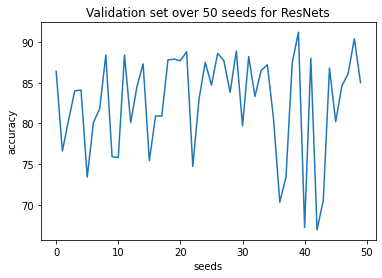

In [6]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation set over 50 seeds for ResNets');
plt.savefig('C1val50seeds_trivialAugment.png')